## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal, io
from scipy.ndimage import median_filter as medfilt
from scipy.signal import correlate
from matplotlib import ticker

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils.extmath import randomized_svd as rsvd

from utils import tic, toc, hankel_matrix, legendre_polys, find_opt_lag, generate_color_gradient

from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
cold_hot = nilearn_cmaps['cold_hot']

%matplotlib inline

In [2]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [3]:
def plot_allen(ax):
    allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']
    for i in range(len(allen_ccf)):
        temp1 = allen_ccf[i]
        #temp1[np.abs(temp1)>200]=np.nan
        ax.plot(temp1[:,0],temp1[:,1],'w',lw=.5)

## Load and preprocess data

In [4]:
data_dir = '/home/ryanr/widefield'
outdir = '/home/ryanr/Allen/arousal_final/model_predictions'
figdir = '/home/ryanr/Allen/arousal_final/figs'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [5]:
def load_brain(subj,modality='jrgeco',filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_' + modality + '.mat')
    brain = data_dict['data'][:,mask_long]

    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        brain = signal.sosfiltfilt(sos, brain, axis=0)
        
    brain = brain[1000:-800,:]
    
    brain = StandardScaler(with_std=False).fit_transform(brain)

    return brain

In [6]:
def load_pupil(subj,filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_pupil.mat')
    pupil = data_dict['pupil'].reshape(-1,1)
    pupil = medfilt(pupil,21)
    
    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        pupil = signal.sosfiltfilt(sos, pupil, axis=0)
    
    pupil = pupil[1000:-800,:]
    
    pupil = StandardScaler(with_std=False).fit_transform(pupil)

    return pupil

In [7]:
## Set delay embedding parameters

Fs = 20 # sampling frequency
dt = 1/Fs
stackmax = 100 # Hankel row dimension (i.e., number of time shifts)
spacing = 3 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)

## Compute and save PCs for all modalities and mice

In [8]:
subs = [4,5,6,7,8,9,10]

for i in range(len(subs)):
            
    print(f'Mouse {i+1}')
        
    for modality in ['jrgeco','fad','hemo1']:
    
        tic()

        brain = load_brain(subs[i],modality)[spacing*(stackmax-1):,:]
        brain = StandardScaler(with_std=False).fit_transform(brain)

        u,sigmas,vh = rsvd(brain, n_components=200)

        np.save(outdir + '/../PCs/' + str(subs[i]) + '_' + modality + '_sigmas.npy', sigmas)
        np.save(outdir + '/../PCs/' + str(subs[i]) + '_' + modality + '_spatial_modes.npy', vh)

        toc()

Fold 1
Elapsed time is 13.361547470092773 seconds.
Fold 1
Elapsed time is 13.044467449188232 seconds.
Fold 1
Elapsed time is 12.29694938659668 seconds.
Fold 2
Elapsed time is 12.345981359481812 seconds.
Fold 2
Elapsed time is 12.954809427261353 seconds.
Fold 2
Elapsed time is 21.05212092399597 seconds.
Fold 3
Elapsed time is 21.374849796295166 seconds.
Fold 3
Elapsed time is 12.238827228546143 seconds.
Fold 3
Elapsed time is 12.217887878417969 seconds.
Fold 4
Elapsed time is 12.372496128082275 seconds.
Fold 4
Elapsed time is 13.623780488967896 seconds.
Fold 4
Elapsed time is 12.526080131530762 seconds.
Fold 5
Elapsed time is 12.508666276931763 seconds.
Fold 5
Elapsed time is 12.52554178237915 seconds.
Fold 5
Elapsed time is 11.998573303222656 seconds.
Fold 6
Elapsed time is 12.78311824798584 seconds.
Fold 6
Elapsed time is 12.885504245758057 seconds.
Fold 6
Elapsed time is 12.056065559387207 seconds.
Fold 7
Elapsed time is 12.389039516448975 seconds.
Fold 7
Elapsed time is 12.583912849

# Scree plots

<IPython.core.display.Javascript object>


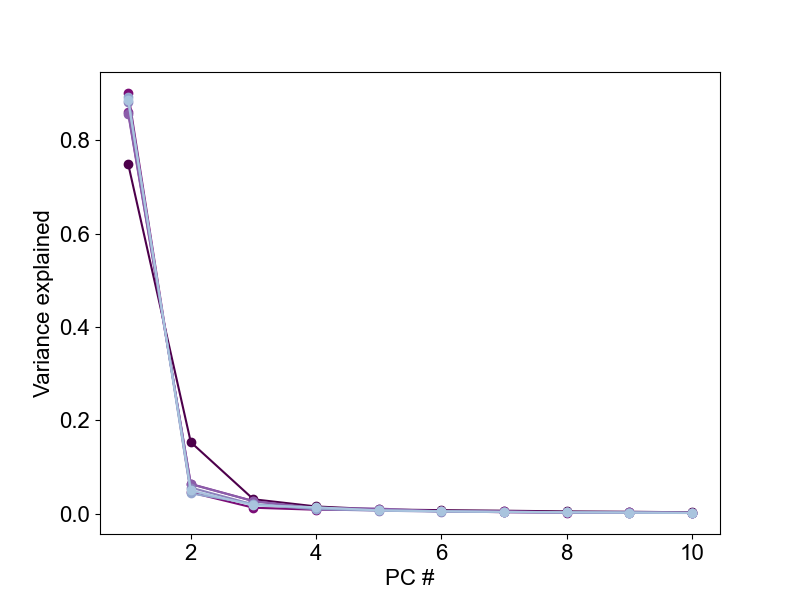

In [9]:
modality = 'jrgeco'
line_colors = generate_color_gradient(len(subs)+3,modality)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subs)):
    sigmas = np.load(outdir + '/../PCs/' + str(subs[i]) + '_' + modality + '_sigmas.npy')
    plt.plot(np.arange(1,11),(sigmas[:10]**2)/np.sum(sigmas**2),markersize=12, marker = '.', color=line_colors[i])
               
plt.xlabel('PC #')
plt.ylabel('Variance explained')

plt.savefig(figdir + '/scree_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

<IPython.core.display.Javascript object>


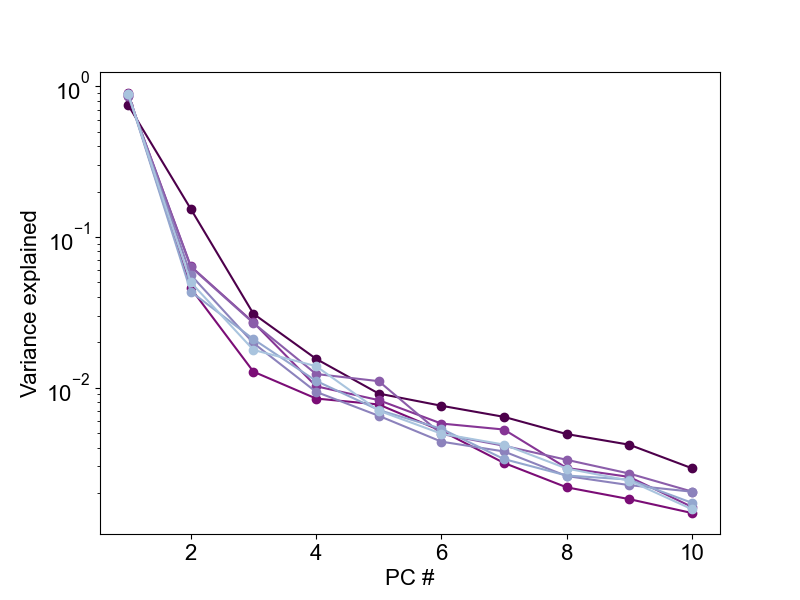

In [10]:
line_colors = generate_color_gradient(len(subs)+3,modality)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subs)):
    sigmas = np.load(outdir + '/../PCs/' + str(subs[i]) + '_' + modality + '_sigmas.npy')
    plt.plot(np.arange(1,11),(sigmas[:10]**2)/np.sum(sigmas**2),markersize=12, marker = '.', color=line_colors[i])

plt.yscale('log')
plt.xlabel('PC #')
plt.ylabel('Variance explained')

plt.savefig(figdir + '/scree_log_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

<IPython.core.display.Javascript object>


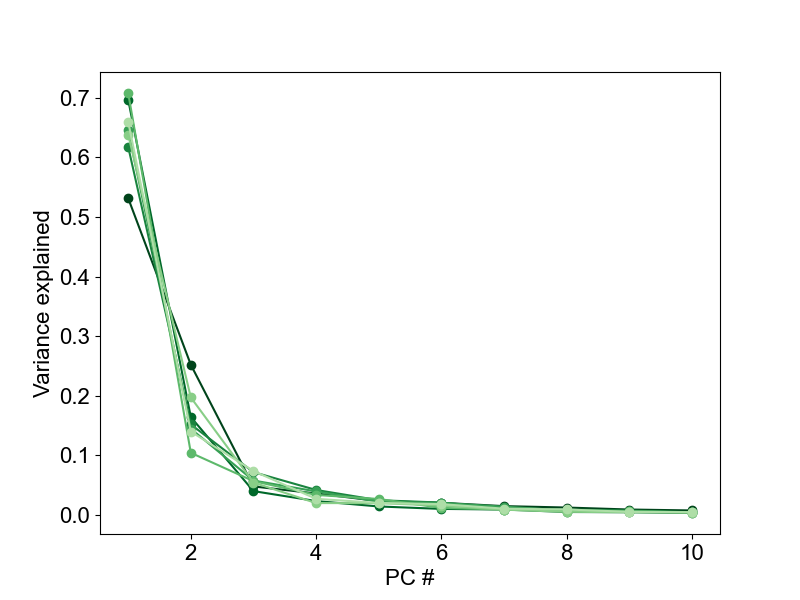

In [11]:
modality = 'fad'
line_colors = generate_color_gradient(len(subs)+3,modality)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subs)):
    sigmas = np.load(outdir + '/../PCs/' + str(subs[i]) + '_' + modality + '_sigmas.npy')
    plt.plot(np.arange(1,11),(sigmas[:10]**2)/np.sum(sigmas**2),markersize=12, marker = '.', color=line_colors[i])
               
plt.xlabel('PC #')
plt.ylabel('Variance explained')

plt.savefig(figdir + '/scree_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

<IPython.core.display.Javascript object>


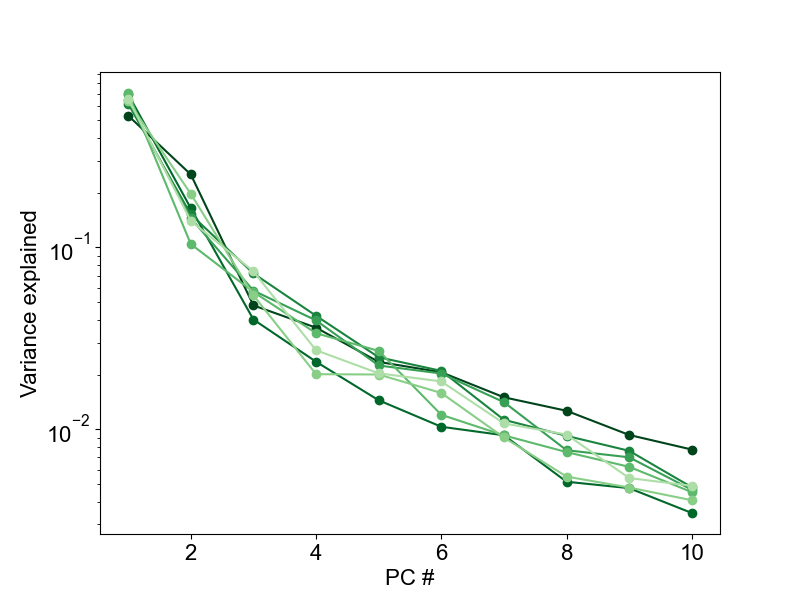

In [12]:
line_colors = generate_color_gradient(len(subs)+3,modality)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subs)):
    sigmas = np.load(outdir + '/../PCs/' + str(subs[i]) + '_' + modality + '_sigmas.npy')
    plt.plot(np.arange(1,11),(sigmas[:10]**2)/np.sum(sigmas**2),markersize=12, marker = '.', color=line_colors[i])

plt.yscale('log')
plt.xlabel('PC #')
plt.ylabel('Variance explained')

plt.savefig(figdir + '/scree_log_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

<IPython.core.display.Javascript object>


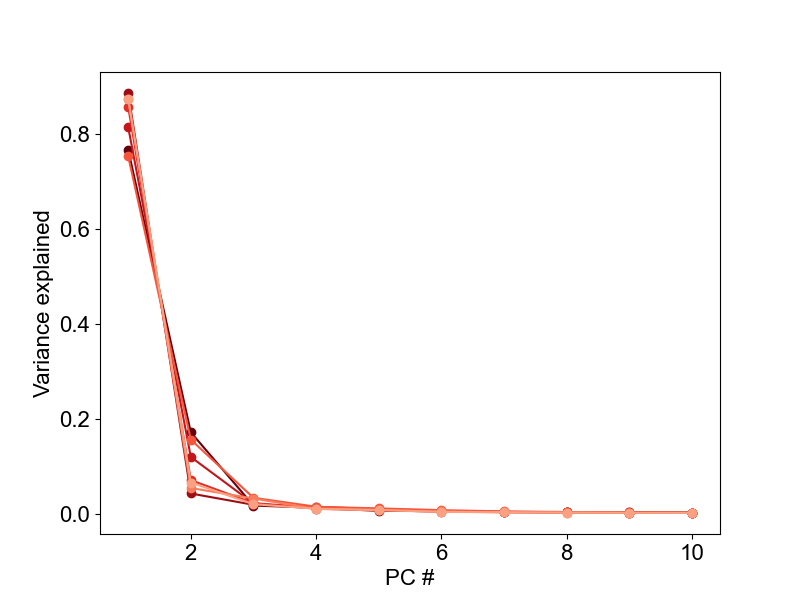

In [13]:
modality = 'hemo1'
line_colors = generate_color_gradient(len(subs)+3,modality)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subs)):
    sigmas = np.load(outdir + '/../PCs/' + str(subs[i]) + '_' + modality + '_sigmas.npy')
    plt.plot(np.arange(1,11),(sigmas[:10]**2)/np.sum(sigmas**2),markersize=12, marker = '.', color=line_colors[i])
               
plt.xlabel('PC #')
plt.ylabel('Variance explained')

plt.savefig(figdir + '/scree_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

<IPython.core.display.Javascript object>


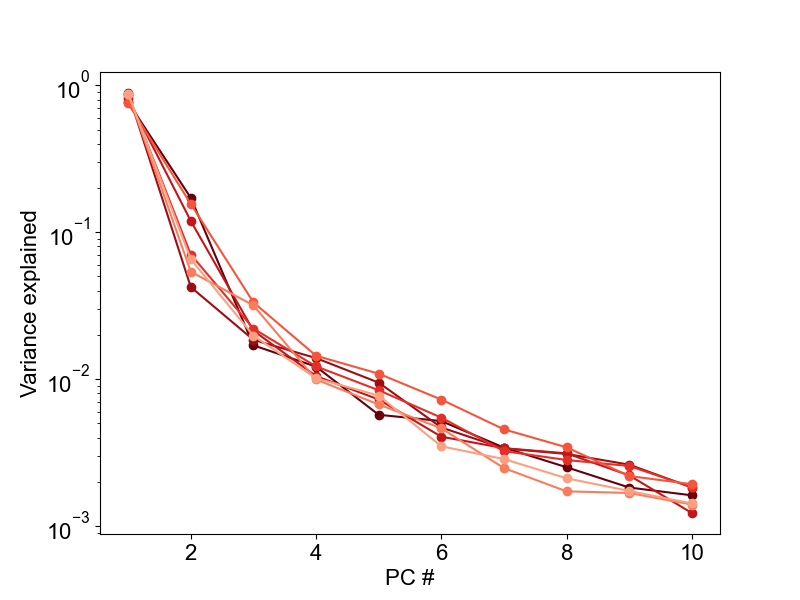

In [14]:
line_colors = generate_color_gradient(len(subs)+3,modality)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subs)):
    sigmas = np.load(outdir + '/../PCs/' + str(subs[i]) + '_' + modality + '_sigmas.npy')
    plt.plot(np.arange(1,11),(sigmas[:10]**2)/np.sum(sigmas**2),markersize=12, marker = '.', color=line_colors[i])

plt.yscale('log')
plt.xlabel('PC #')
plt.ylabel('Variance explained')

plt.savefig(figdir + '/scree_log_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

# PC maps

<IPython.core.display.Javascript object>


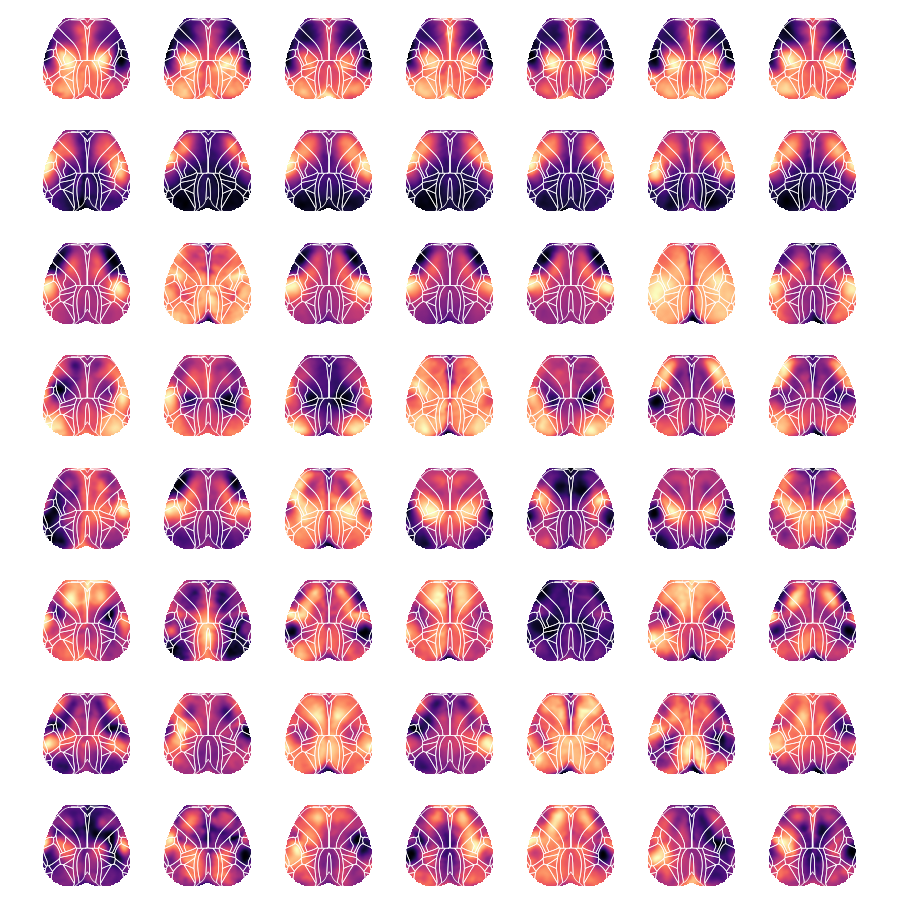

In [15]:
num_plots = 8
modality = 'jrgeco'

fig, axes = plt.subplots(num_plots,len(subs),sharex='col',figsize=(9,9),layout='compressed')

axes = axes.reshape(num_plots,len(subs))

templates = np.load(outdir + '/../PCs/' + str(subs[-1]) + '_' + modality + '_spatial_modes.npy')

for s in range(len(subs)):
    spatial_modes = np.load(outdir + '/../PCs/' + str(subs[s]) + '_' + modality + '_spatial_modes.npy')

    for i, ax in enumerate(axes[:,s]):

        temp = np.zeros((16384,1), dtype=np.single)
        temp[mask_long] = spatial_modes.T[:,i].reshape(-1,1)
        
        if (np.dot(temp[mask_long].T, templates.T[:,i].reshape(-1,1)) < 0):
            temp[mask_long] *= -1
        
        temp = np.ma.masked_where(temp==0, temp)
        temp = temp.reshape(128,128,order='F')
        im = ax.imshow(temp, cmap = 'magma')
        
        plot_allen(ax)
        ax.axis('off')
        
plt.savefig(figdir + '/figs/PCmaps_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

<IPython.core.display.Javascript object>


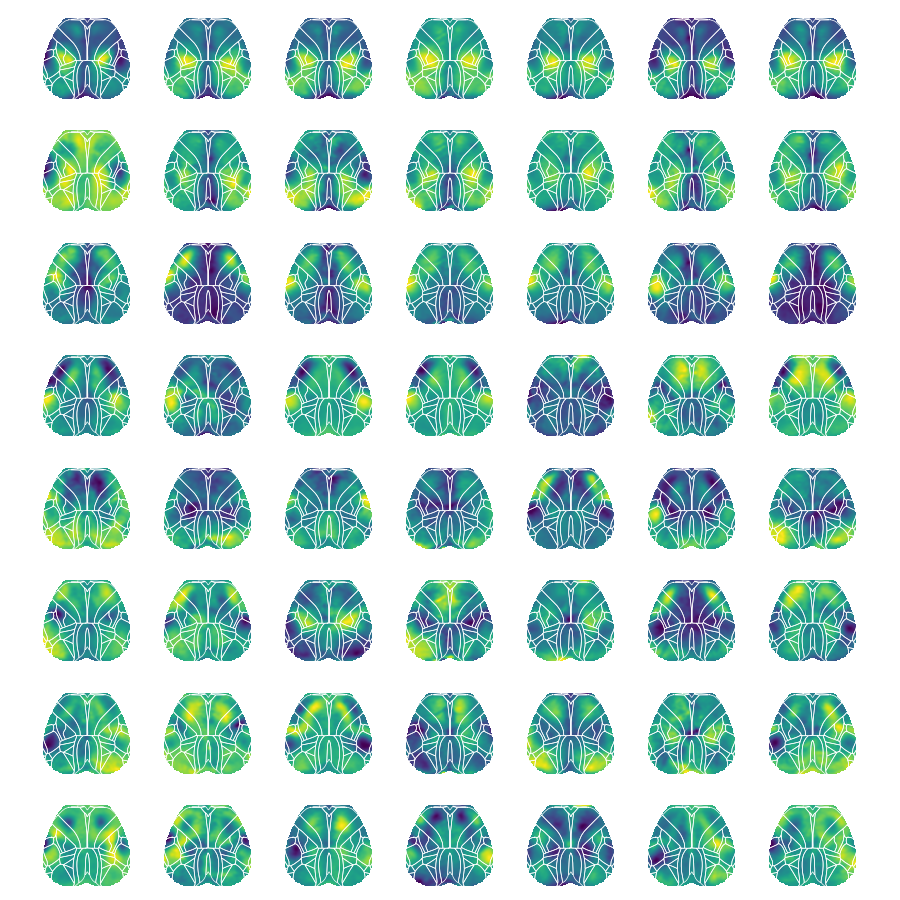

In [16]:
num_plots = 8
modality = 'fad'

fig, axes = plt.subplots(num_plots,len(subs),sharex='col',figsize=(9,9),layout='compressed')

axes = axes.reshape(num_plots,len(subs))

templates = np.load(outdir + '/../PCs/' + str(subs[-1]) + '_' + modality + '_spatial_modes.npy')

for s in range(len(subs)):
    spatial_modes = np.load(outdir + '/../PCs/' + str(subs[s]) + '_' + modality + '_spatial_modes.npy')

    for i, ax in enumerate(axes[:,s]):

        temp = np.zeros((16384,1), dtype=np.single)
        temp[mask_long] = spatial_modes.T[:,i].reshape(-1,1)
        
        if (np.dot(temp[mask_long].T, templates.T[:,i].reshape(-1,1)) < 0):
            temp[mask_long] *= -1
        
        temp = np.ma.masked_where(temp==0, temp)
        temp = temp.reshape(128,128,order='F')
        im = ax.imshow(temp, cmap = 'viridis')
        
        plot_allen(ax)
        ax.axis('off')
        
plt.savefig(figdir + '/PCmaps_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

<IPython.core.display.Javascript object>


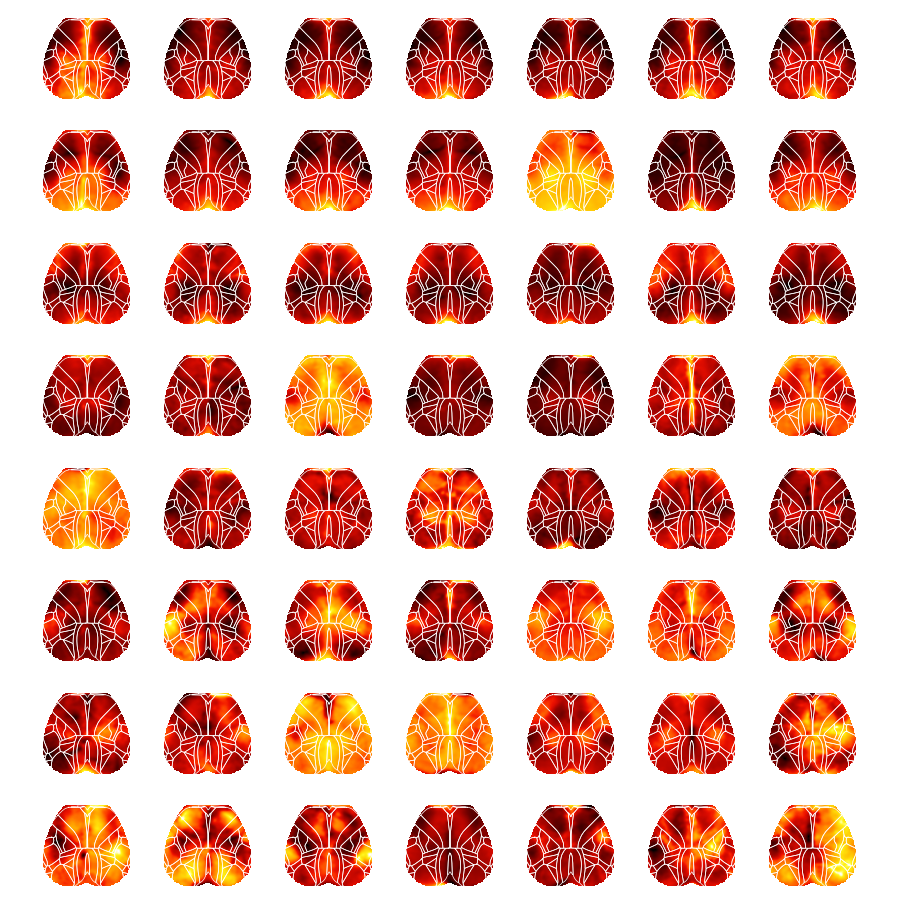

In [17]:
num_plots = 8
modality = 'hemo1'

fig, axes = plt.subplots(num_plots,len(subs),sharex='col',figsize=(9,9),layout='compressed')

axes = axes.reshape(num_plots,len(subs))

templates = np.load(outdir + '/../PCs/' + str(subs[-1]) + '_' + modality + '_spatial_modes.npy')

for s in range(len(subs)):
    spatial_modes = np.load(outdir + '/../PCs/' + str(subs[s]) + '_' + modality + '_spatial_modes.npy')

    for i, ax in enumerate(axes[:,s]):

        temp = np.zeros((16384,1), dtype=np.single)
        temp[mask_long] = spatial_modes.T[:,i].reshape(-1,1)
        
        if (np.dot(temp[mask_long].T, templates.T[:,i].reshape(-1,1)) < 0):
            temp[mask_long] *= -1
        
        temp = np.ma.masked_where(temp==0, temp)
        temp = temp.reshape(128,128,order='F')
        im = ax.imshow(temp, cmap = cc.cm.CET_L3)
        
        plot_allen(ax)
        ax.axis('off')
        
plt.savefig(figdir + '/PCmaps_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

## Legendre maps

In [18]:
from sklearn.linear_model import LinearRegression

def linear_regression(x,y):
    
    L = LinearRegression()
    L.fit(x,y)
    y_hat = L.predict(x)
    r_squared = r2_score(y, y_hat, multioutput='raw_values')
    
    return r_squared, L

In [19]:
subs = [4,5,6,7,8,9,10]
xcorrs = np.zeros((brain.shape[1],len(subs),10))

num_plots = 5

polys = legendre_polys(r, stackmax)

for s in range(len(subs)):
    
    tic()
        
    pupil = load_pupil(subs[s])
    brain = load_brain(subs[s])
    
    # Find lag
    lag_range = 5 # range over which to look for optimal lag between pupil and brain cross-correlation (in seconds)
    lag_range = int(lag_range/dt)
    lag,_,_ = find_opt_lag(pupil,np.mean(brain,axis=1),lag_range)    
    
    if lag>0:
        pupil = pupil[lag:,:]
        brain = brain[:-lag,:]
    
    # Time delay embedding
    Hp = hankel_matrix(pupil.T,stackmax,spacing)
    brain = brain[spacing*(stackmax-1):,:]
    
    for m in range(num_plots):
        signal1 = Hp.T@polys[:,m:m+1]
        xcorrs[:,s,m],_ = linear_regression(signal1, brain)
    
    toc()


Elapsed time is 21.62266254425049 seconds.
Elapsed time is 21.49361801147461 seconds.
Elapsed time is 21.942534923553467 seconds.
Elapsed time is 22.014595985412598 seconds.
Elapsed time is 22.081159114837646 seconds.
Elapsed time is 22.158748149871826 seconds.
Elapsed time is 21.89159893989563 seconds.


<IPython.core.display.Javascript object>


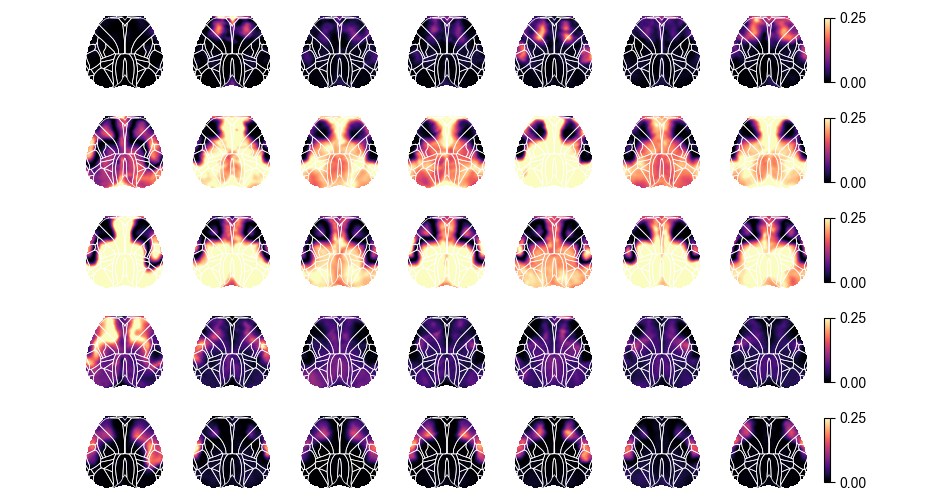

In [20]:
fig, axes = plt.subplots(num_plots,len(subs),sharex='col',figsize=(9.42,5), layout='compressed')

axes = axes.flatten()
for i, ax in enumerate(axes):
    temp = np.zeros((16384,1), dtype=np.single)
    temp[mask_long] = xcorrs[:,np.mod(i,len(subs)),i//len(subs)].reshape(-1,1)
    temp = np.ma.masked_where(temp==0, temp)
    temp = temp.reshape(128,128,order='F')
    
    im = ax.imshow(temp, vmin=0, vmax=.25, cmap='magma')
    
    if np.mod(i,len(subs))==len(subs)-1:
        cbar=plt.colorbar(im, ax=ax, aspect=10, shrink=.7)
        cbar.set_ticks([0, .25])
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        cbar.ax.yaxis.set_tick_params(labelsize=10)
        
    plot_allen(ax)
    ax.axis('off')
    
plt.savefig(figdir + '/legendre_maps.pdf', dpi=300, transparent=True)

plt.show()

## Derivative maps

In [21]:
subs = [4,5,6,7,8,9,10]
xcorrs = np.zeros((brain.shape[1],len(subs),6))

polys = legendre_polys(r, stackmax)

for s in range(len(subs)):
    
    tic()
        
    pupil = load_pupil(subs[s])
    brain = load_brain(subs[s])
    
    # Find lag
    lag_range = 5 # range over which to look for optimal lag between pupil and brain cross-correlation (in seconds)
    lag_range = int(lag_range/dt)
    lag,_,_ = find_opt_lag(pupil,np.mean(brain,axis=1),lag_range)    
    
    if lag>0:
        pupil = pupil[lag:,:]
        brain = brain[:-lag,:]
       
    for m in range(num_plots):
        if m>0:
            signal1 = np.diff(pupil.T,n=m,prepend=pupil[:m,:].T).T
        else:
            signal1=pupil.copy()
        xcorrs[:,s,m],_ = linear_regression(signal1, brain)
    
    toc()


Elapsed time is 21.94454264640808 seconds.
Elapsed time is 22.27442502975464 seconds.
Elapsed time is 22.157514810562134 seconds.
Elapsed time is 22.1789071559906 seconds.
Elapsed time is 22.296766996383667 seconds.
Elapsed time is 22.38427186012268 seconds.
Elapsed time is 22.103238582611084 seconds.


<IPython.core.display.Javascript object>


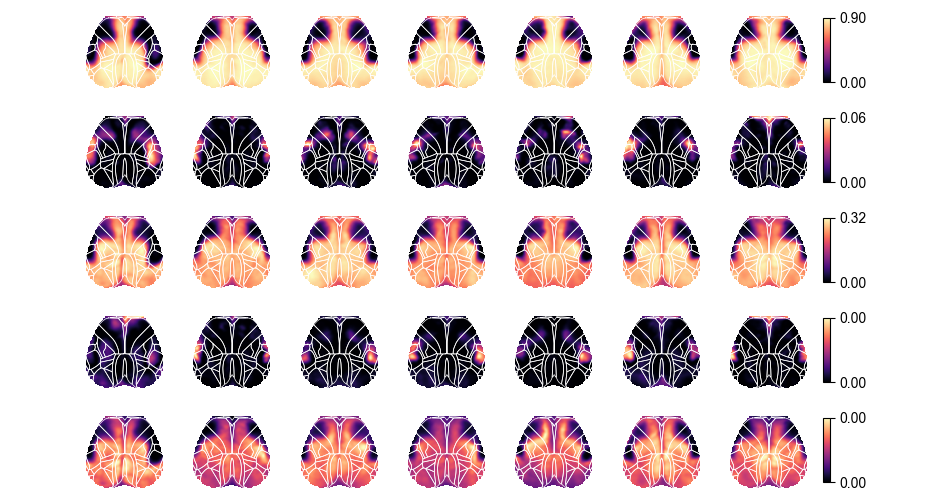

In [22]:
fig, axes = plt.subplots(num_plots,len(subs),sharex='col',figsize=(9.42,5), layout='compressed')
axes = axes.flatten()
for i, ax in enumerate(axes):
    temp = np.zeros((16384,1), dtype=np.single)
    temp[mask_long] = xcorrs[:,np.mod(i,len(subs)),i//len(subs)].reshape(-1,1)
    temp = np.ma.masked_where(temp==0, temp)
    temp = temp.reshape(128,128,order='F')
    
    im = ax.imshow(temp, vmin=np.min(temp), vmax=np.max(temp), cmap='magma')

    if np.mod(i,len(subs))==len(subs)-1:
        cbar=plt.colorbar(im, ax=ax, aspect=10, shrink=.7)
        cbar.set_ticks([np.min(temp), np.max(temp)])
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        cbar.ax.yaxis.set_tick_params(labelsize=10)
        
    plot_allen(ax)
    ax.axis('off')

plt.savefig(figdir + '/derivative_maps.pdf', dpi=300, transparent=True)

plt.show()

# Between-modality predictions

## jRGECO x FAD

In [23]:
xcorrs = np.zeros((brain.shape[1],len(subs),2))

for s in range(len(subs)):
    
    tic()
        
    jrgeco = load_brain(subs[s],'jrgeco')
    fad = load_brain(subs[s],'fad')
    
    # Find lag
    lag_range = 5 # range over which to look for optimal lag between pupil and brain cross-correlation (in seconds)
    lag_range = int(lag_range/dt)
    max_lag = fad.shape[0]-1
    
    cross_corrs = np.array([
        correlate(fad[:,i].reshape(-1), jrgeco[:,i].reshape(-1), mode='full') / 
        (np.std(fad[:,i]) * np.std(jrgeco[:,i])*fad.shape[0])
            for i in range(fad.shape[1])
        ])
    
    lag_inds = np.arange(-max_lag, max_lag + 1)
    cross_corrs[:,np.abs(lag_inds)>max_lag] = 0
    
    xcorrs[:,s,0] = (np.argmax(cross_corrs, axis=1) - max_lag)*dt
    xcorrs[:,s,1] = cross_corrs[np.arange(fad.shape[1]),np.argmax(cross_corrs, axis=1)]**2
    
    toc()


Elapsed time is 22.00268864631653 seconds.
Elapsed time is 21.81248188018799 seconds.
Elapsed time is 21.587576627731323 seconds.
Elapsed time is 21.738783836364746 seconds.
Elapsed time is 21.907132625579834 seconds.
Elapsed time is 22.437947273254395 seconds.
Elapsed time is 21.880485773086548 seconds.


<IPython.core.display.Javascript object>


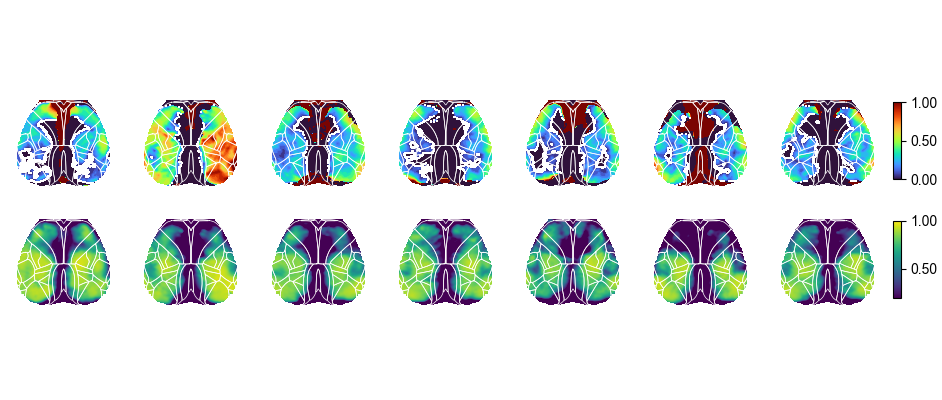

In [24]:
fig, axes = plt.subplots(2,len(subs),sharex='col',figsize=(9.42,4), layout='compressed')

axes = axes.flatten()

for i, ax in enumerate(axes):
    temp = np.zeros((16384,1), dtype=np.single)
    temp[mask_long] = xcorrs[:,np.mod(i,len(subs)),i//len(subs)].reshape(-1,1)
    temp = np.ma.masked_where(temp==0, temp)
    temp = temp.reshape(128,128,order='F')
    
    if i//len(subs)==0:
        im = ax.imshow(temp, vmin=0, vmax=1, cmap = 'turbo')
    else:
        im = ax.imshow(temp, vmin=.2, vmax=1, cmap = 'viridis')
        
    if np.mod(i,len(subs))==len(subs)-1:
        cbar=plt.colorbar(im, ax=ax, aspect=10, shrink=.7)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        cbar.ax.yaxis.set_tick_params(labelsize=10)
        
    plot_allen(ax)
    ax.axis('off')
    
plt.savefig(figdir + '/r2_maps_jrgeco_fad.pdf', dpi=300, transparent=True)

plt.show()

## jRGECO x Hemo

In [25]:
xcorrs = np.zeros((brain.shape[1],len(subs),2))

for s in range(len(subs)):
    
    tic()
        
    jrgeco = load_brain(subs[s],'jrgeco')
    hemo1 = load_brain(subs[s],'hemo1')
    
    # Find lag
    lag_range = 5 # range over which to look for optimal lag between pupil and brain cross-correlation (in seconds)
    lag_range = int(lag_range/dt)
    max_lag = hemo1.shape[0]-1
    
    cross_corrs = np.array([
        correlate(hemo1[:,i].reshape(-1), jrgeco[:,i].reshape(-1), mode='full') / 
        (np.std(hemo1[:,i]) * np.std(jrgeco[:,i])*hemo1.shape[0])
            for i in range(hemo1.shape[1])
        ])
    
    lag_inds = np.arange(-max_lag, max_lag + 1)
    cross_corrs[:,np.abs(lag_inds)>max_lag] = 0
    
    xcorrs[:,s,0] = (np.argmax(cross_corrs, axis=1) - max_lag)*dt
    xcorrs[:,s,1] = cross_corrs[np.arange(hemo1.shape[1]),np.argmax(cross_corrs, axis=1)]**2
    
    toc()


Elapsed time is 22.433000087738037 seconds.
Elapsed time is 22.306169033050537 seconds.
Elapsed time is 22.079343557357788 seconds.
Elapsed time is 22.235687732696533 seconds.
Elapsed time is 22.410889387130737 seconds.
Elapsed time is 22.4984073638916 seconds.
Elapsed time is 22.023132801055908 seconds.


<IPython.core.display.Javascript object>


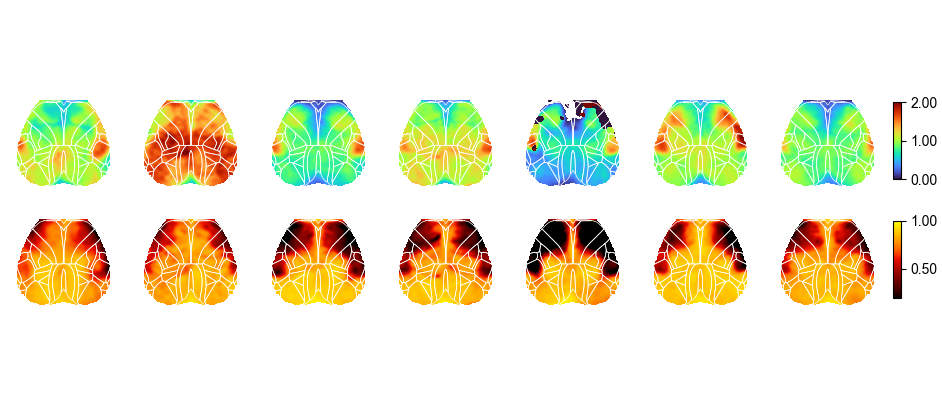

In [26]:
fig, axes = plt.subplots(2,len(subs),sharex='col',figsize=(9.42,4), layout='compressed')

axes = axes.flatten()

for i, ax in enumerate(axes):
    temp = np.zeros((16384,1), dtype=np.single)
    temp[mask_long] = xcorrs[:,np.mod(i,len(subs)),i//len(subs)].reshape(-1,1)
    temp = np.ma.masked_where(temp==0, temp)
    temp = temp.reshape(128,128,order='F')
    
    if i//len(subs)==0:
        im = ax.imshow(temp, vmin=0, vmax=2, cmap = 'turbo')
    else:
        im = ax.imshow(temp, vmin=.2, vmax=1, cmap = cc.cm.CET_L4)
        
    if np.mod(i,len(subs))==len(subs)-1:
        cbar=plt.colorbar(im, ax=ax, aspect=10, shrink=.7)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        cbar.ax.yaxis.set_tick_params(labelsize=10)
        
    plot_allen(ax)
    ax.axis('off')
    
plt.savefig(figdir + '/r2_maps_jrgeco_hemo1.pdf', dpi=300, transparent=True)

plt.show()